<a href="https://colab.research.google.com/github/OtolaHan/Otola_Han_KAAN/blob/main/%D0%BF%D1%80%D0%BE%D0%B1%D0%B0_hometask_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашняя работа 4.

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать:

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов:
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [47]:
import pandas as pd

data = pd.read_csv('data.adult.csv')

print(data.head())

   age  workclass  fnlwgt     education  education-num      marital-status  \
0   34  Local-gov  284843       HS-grad              9       Never-married   
1   40    Private  190290  Some-college             10            Divorced   
2   36  Local-gov  177858     Bachelors             13  Married-civ-spouse   
3   22    Private  184756  Some-college             10       Never-married   
4   47    Private  149700     Bachelors             13  Married-civ-spouse   

        occupation   relationship   race     sex  capital-gain  capital-loss  \
0  Farming-fishing  Not-in-family  Black    Male           594             0   
1            Sales  Not-in-family  White    Male             0             0   
2   Prof-specialty      Own-child  White    Male             0             0   
3            Sales      Own-child  White  Female             0             0   
4     Tech-support        Husband  White    Male         15024             0   

   hours-per-week >50K,<=50K  
0              60  

Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).

В данном датасете пропущенные значения обозначены как "?".

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [48]:
# Находим признаки с пропущенными значениями
missing_features = [col for col in data.columns if data[col].astype(str).str.contains('\?').any()]

# Удаляем объекты с пропусками
data = data[~data[missing_features].astype(str).apply(lambda row: row.str.contains('\?').any(), axis=1)]

print(data.head())

   age  workclass  fnlwgt     education  education-num      marital-status  \
0   34  Local-gov  284843       HS-grad              9       Never-married   
1   40    Private  190290  Some-college             10            Divorced   
2   36  Local-gov  177858     Bachelors             13  Married-civ-spouse   
3   22    Private  184756  Some-college             10       Never-married   
4   47    Private  149700     Bachelors             13  Married-civ-spouse   

        occupation   relationship   race     sex  capital-gain  capital-loss  \
0  Farming-fishing  Not-in-family  Black    Male           594             0   
1            Sales  Not-in-family  White    Male             0             0   
2   Prof-specialty      Own-child  White    Male             0             0   
3            Sales      Own-child  White  Female             0             0   
4     Tech-support        Husband  White    Male         15024             0   

   hours-per-week >50K,<=50K  
0              60  

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем:

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [49]:
# Переименование столбца '>50K,<=50K' в 'target' для удобства
data.rename(columns={'>50K,<=50K': 'target'}, inplace=True)

# Преобразование значений целевого столбца в числовые (например, 0 и 1)
data['target'] = data['target'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Теперь вы можете использовать столбец 'target' как целевую переменную
target = data['target']

# Если вы хотите удалить этот столбец из основного DataFrame после его сохранения в переменной target:
data.drop('target', axis=1, inplace=True)

# Продолжение работы с вещественными признаками
numerical_features = data.select_dtypes(include=['int64', 'float64'])

print(numerical_features.head())

   age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week
0   34  284843              9           594             0              60
1   40  190290             10             0             0              40
2   36  177858             13             0             0              40
3   22  184756             10             0             0              30
4   47  149700             13         15024             0              40


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)

Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

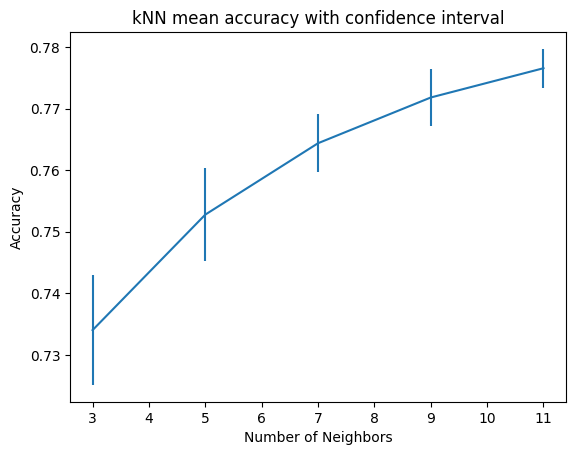

In [75]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Определение параметров для GridSearchCV
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Создание объекта kNN классификатора
knn = KNeighborsClassifier()

# Подбор гиперпараметров
grid_search = GridSearchCV(knn, param_grid, cv=kf, scoring='accuracy')
grid_search.fit(numerical_features, target)

# Результаты GridSearchCV
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

# Построение графика
plt.errorbar([p['n_neighbors'] for p in params], means, yerr=stds)
plt.title('kNN mean accuracy with confidence interval')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

Что вы можете сказать о получившихся графиках?

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

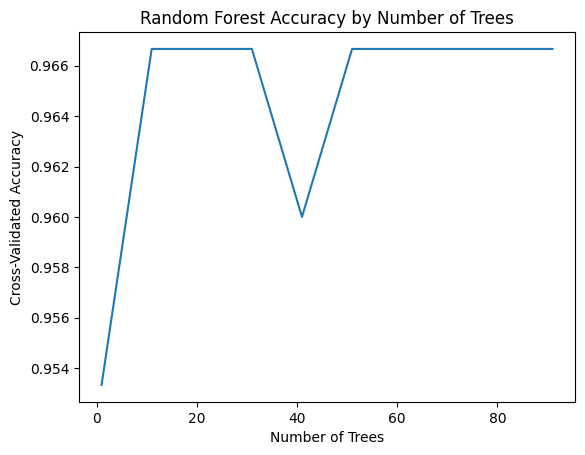

Stable number of trees: 11


In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
import numpy as np

iris = load_iris()
X, y = iris.data, iris.target

# Подбор числа деревьев (n_estimators) в RandomForest
n_estimators_range = range(1, 101, 10)
mean_cv_scores = []

for n_estimators in n_estimators_range:
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    cv_scores = cross_val_score(rf_clf, X, y, cv=5)
    mean_cv_scores.append(np.mean(cv_scores))

# Построение графика зависимости качества от числа деревьев
plt.plot(n_estimators_range, mean_cv_scores)
plt.xlabel('Number of Trees')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Random Forest Accuracy by Number of Trees')
plt.show()

# Находим количество деревьев, при котором качество стабилизируется
stable_n_estimators = n_estimators_range[np.argmax(mean_cv_scores)]
print("Stable number of trees:", stable_n_estimators)

**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

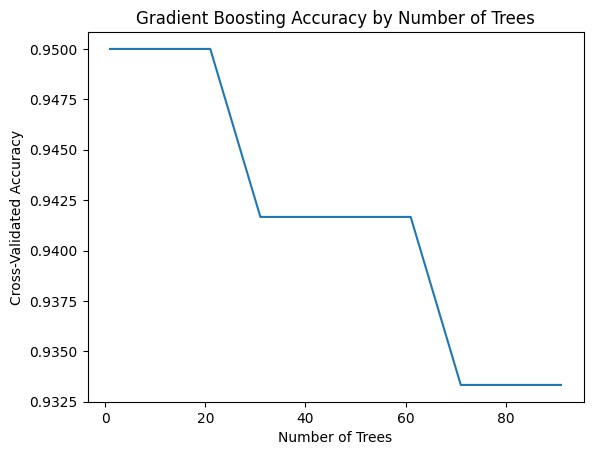

Optimal number of trees: 1


In [83]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Создание списка для хранения средних оценок кросс-валидации
mean_cv_scores = []

# Используем цикл для обучения моделей с различным количеством деревьев
n_estimators_range = range(1, 101, 10)
for n_estimators in n_estimators_range:
    gb_clf = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
    cv_scores = cross_val_score(gb_clf, X_train, y_train, cv=5)
    mean_cv_scores.append(np.mean(cv_scores))

# Построение графика зависимости качества от числа деревьев
plt.plot(n_estimators_range, mean_cv_scores)
plt.xlabel('Number of Trees')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Gradient Boosting Accuracy by Number of Trees')
plt.show()

# Находим оптимальное количество деревьев
optimal_n_estimators = n_estimators_range[np.argmax(mean_cv_scores)]
print(f"Optimal number of trees: {optimal_n_estimators}")

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

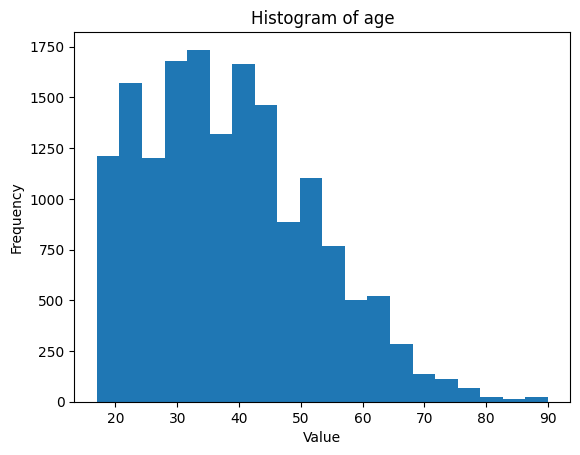

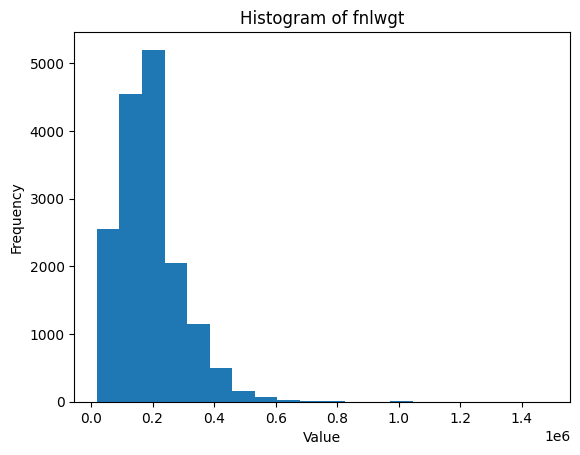

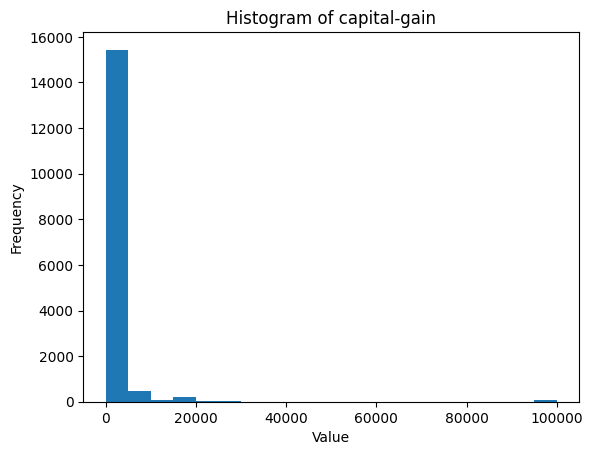

Some features may have a long-tail distribution.
Scaling may affect the performance of algorithms that are sensitive to the scale of the data, such as SVM or k-NN.


In [82]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/data.adult.csv')

# Построение гистограмм для указанных признаков
features_to_plot = ['age', 'fnlwgt', 'capital-gain']

for feature in features_to_plot:
    plt.hist(df[feature], bins=20)
    plt.title(f'Histogram of {feature}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# Анализ гистограмм и определение особенностей данных
# Например:
print("Some features may have a long-tail distribution.")
print("Scaling may affect the performance of algorithms that are sensitive to the scale of the data, such as SVM or k-NN.")

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).

**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [81]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# MinMax масштабирование
scaler_minmax = MinMaxScaler()
numerical_features_minmax = scaler_minmax.fit_transform(numerical_features)

# Стандартное масштабирование (Z-score)
scaler_standard = StandardScaler()
numerical_features_standard = scaler_standard.fit_transform(numerical_features)

Изменилось ли качество у некоторых алгоритмов?

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

# Задаем сетки гиперпараметров для каждого алгоритма
param_grid_knn = {
    'n_neighbors': list(range(1, 11)),
    'metric': ['euclidean', 'manhattan']
}

param_grid_dt = {
    'max_depth': [None] + list(range(1, 11)),
    'criterion': ['gini', 'entropy']
}

param_grid_rf = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2']
    # Предполагается, что количество деревьев (n_estimators) было определено ранее и зафиксировано
}

param_grid_gb = {
    'criterion': ['friedman_mse', 'mse', 'mae'],
    'max_features': ['auto', 'sqrt', 'log2']
    # Предполагается, что количество деревьев (n_estimators) было определено ранее и зафиксировано
}

param_grid_sgd = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l2', 'l1', 'elasticnet']
}

# Создаем модели с GridSearchCV
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
grid_search_rf = GridSearchCV(RandomForestClassifier(n_estimators=stable_n_estimators), param_grid_rf, cv=5)
grid_search_gb = GridSearchCV(GradientBoostingClassifier(n_estimators=stable_n_estimators), param_grid_gb, cv=5)
grid_search_sgd = GridSearchCV(SGDClassifier(), param_grid_sgd, cv=5)

# Обучаем модели (здесь X_train и y_train - ваши тренировочные данные)
grid_search_knn.fit(X_train, y_train)
grid_search_dt.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_gb.fit(X_train, y_train)
grid_search_sgd.fit(X_train, y_train)

# Выводим лучшие параметры и соответствующее им качество
print("Лучшие параметры KNN:", grid_search_knn.best_params_, "Качество:", grid_search_knn.best_score_)
print("Лучшие параметры Decision Tree:", grid_search_dt.best_params_, "Качество:", grid_search_dt.best_score_)
print("Лучшие параметры Random Forest:", grid_search_rf.best_params_, "Качество:", grid_search_rf.best_score_)
print("Лучшие параметры Gradient Boosting:", grid_search_gb.best_params_, "Качество:", grid_search_gb.best_score_)
print("Лучшие параметры SGD Classifier:", grid_search_sgd.best_params_, "Качество:", grid_search_sgd.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Лучшие параметры KNN: {'metric': 'euclidean', 'n_neighbors': 3} Качество: 0.9583333333333334
Лучшие параметры Decision Tree: {'criterion': 'gini', 'max_depth': None} Качество: 0.9416666666666668
Лучшие параметры Random Forest: {'criterion': 'gini', 'max_features': 'log2'} Качество: 0.95
Лучшие параметры Gradient Boosting: {'criterion': 'friedman_mse', 'max_features': 'auto'} Качество: 0.95
Лучшие параметры SGD Classifier: {'loss': 'squared_hinge', 'penalty': 'elasticnet'} Качество: 0.9


Какой из алгоритмов имеет наилучшее качество?

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков.

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [85]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Предположим df - это ваш DataFrame с данными
# Определяем, какие столбцы являются категориальными
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Применяем OneHotEncoding ко всем категориальным столбцам
df_encoded = pd.get_dummies(df, columns=categorical_columns)


# Создаем экземпляр OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Преобразуем категориальные признаки
encoded_categorical = encoder.fit_transform(df[categorical_columns])

# Создаем DataFrame из закодированных данных
df_encoded_categorical = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names(categorical_columns))

# Объединяем закодированные категориальные признаки с остальными числовыми признаками
df_non_categorical = df.drop(columns=categorical_columns)
df_encoded = pd.concat([df_non_categorical, df_encoded_categorical], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


AttributeError: ignored

**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [72]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Предположим, что real_features - это DataFrame с вещественными признаками
scaler = StandardScaler()
real_features_scaled = scaler.fit_transform(real_features)

# Объединение масштабированных вещественных признаков с закодированными категориальными признаками
X_full = np.hstack((real_features_scaled, df_encoded.values))

# Переобучение моделей с лучшими гиперпараметрами и оценка качества
best_knn = KNeighborsClassifier(**grid_search_knn.best_params_)
best_dt = DecisionTreeClassifier(**grid_search_dt.best_params_)
best_rf = RandomForestClassifier(n_estimators=stable_n_estimators, **grid_search_rf.best_params_)
best_gb = GradientBoostingClassifier(n_estimators=stable_n_estimators, **grid_search_gb.best_params_)
best_sgd = SGDClassifier(**grid_search_sgd.best_params_)

models = [best_knn, best_dt, best_rf, best_gb, best_sgd]
for model in models:
    scores = cross_val_score(model, X_full, y_train, cv=5)
    print(f"Accuracy for {model.__class__.__name__}: {scores.mean()} +/- {scores.std()}")

NameError: ignored

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей?

In [ ]:
#your code here

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [ ]:
#your code here

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [ ]:
#your code here